In [9]:
!nvidia-smi

Wed Feb 12 13:30:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX350         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   37C    P0             N/A / 5001W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
from ultralytics import SAM
import cv2
import base64

import numpy as np
import supervision as sv

In [18]:
# Load a model
model = SAM("d:\programing\ML&DL\MY_Work\weights\sam2.1_b.pt")

img = "d:\\programing\\ML&DL\\MY_Work\\yolo-ultralytics\\dog.jpeg"
image_bgr = cv2.imread(img)

In [20]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [21]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(img)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [22]:
widget.bboxes

[{'x': 68, 'y': 246, 'width': 571, 'height': 677, 'label': ''}]

In [23]:
default_box = [{'x': 68, 'y': 246, 'width': 571, 'height': 677, 'label': ''}]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = [
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ]
    for box in boxes
]
print(boxes)

[[68, 246, 639, 923]]



image 1/1 d:\programing\ML&DL\MY_Work\yolo-ultralytics\dog.jpeg: 1024x1024 1 0, 3402.8ms
Speed: 40.2ms preprocess, 3402.8ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)


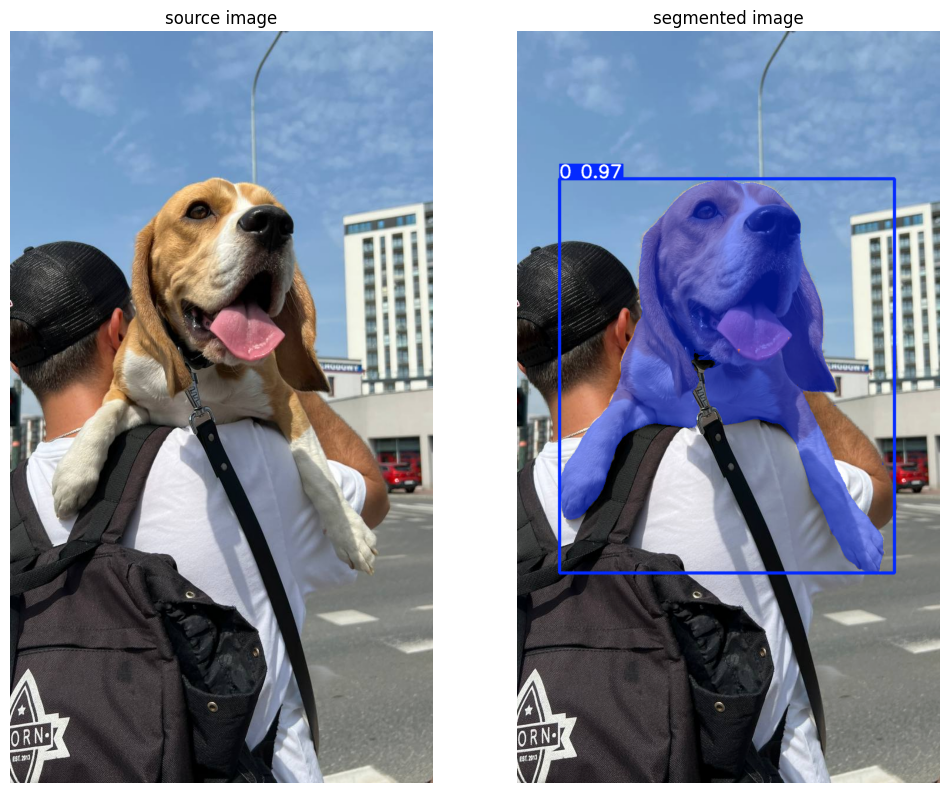

In [24]:
results = model(img, bboxes=boxes)

annotated_img = results[0].plot()
  
sv.plot_images_grid(
    images=[image_bgr, annotated_img],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Segment Anything in Roboflow Universe Dataset

In [25]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

In [ ]:
dataset = r"d:\programing\ML&DL\MY_Work\06-segmentation\MRI-BRAIN-TUMOR-1"

In [40]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [41]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [42]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

In [48]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)

box_annotator = sv.BoxAnnotator(color=sv.Color.BLUE, color_lookup=sv.ColorLookup.INDEX)
# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)


image 1/1 d:\programing\ML&DL\MY_Work\06-segmentation\MRI-BRAIN-TUMOR-1\test\Y15_jpg.rf.ef14d75b886fd9ce299d12ffe480c5e9.jpg: 1024x1024 1 0, 3586.1ms
Speed: 24.7ms preprocess, 3586.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


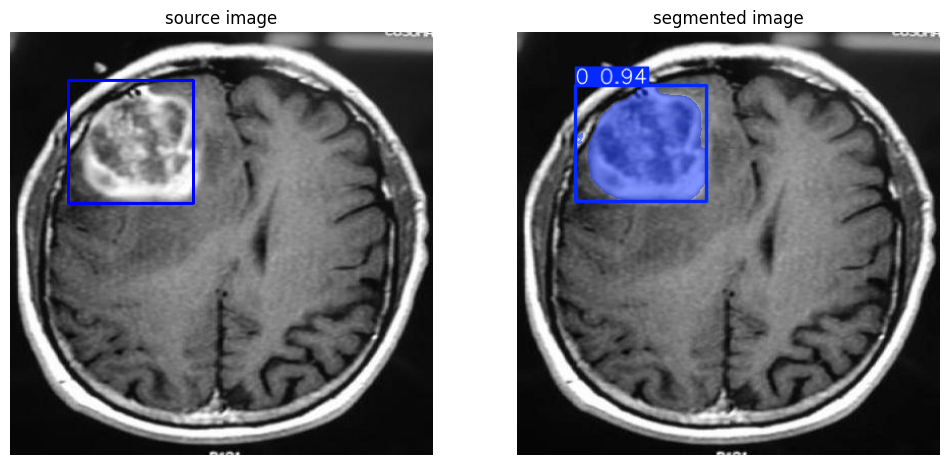

In [49]:
results = model(EXAMPLE_IMAGE_PATH, bboxes=ground_truth.xyxy[0])

annotated_img = results[0].plot()
  
sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_img],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)